# Import Libraries

In [ ]:
%%writefile requirements.txt
tensorflow==2.17.0
keras==3.4.1

Overwriting requirements.txt


In [ ]:
!pip install -r requirements.txt
!pip install keras-cv

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:
import keras_cv
import numpy as np
import os
import tensorflow as tf
import keras as tfk
from keras.layers import Input, Dense, Dropout, Lambda
from keras import layers as tfkl
from keras.utils import to_categorical
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn as scikit_learn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

seed = 42


## Help Functions

In [ ]:
def plot_confusion_matrix(model, X_test, y_test):
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    if y_test.ndim > 1:
        y_test = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(len(cm)))
    disp.plot(cmap='viridis', xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.show()


# Load the Data

In [ ]:
#This time we work on Kagge
#Load the dataset from the .npz file and take "images" and "labels"
data = np.load('/kaggle/input/dataset/training_set_without_outlier.npz')

images = data['images']
labels = data['labels']
print(f'Images shape: {images.shape}')
print(f'Labels shape: {labels.shape}')




#Initial shuffle of the data
indices = np.random.permutation(len(images))
shuffled_images = images[indices]
shuffled_labels = labels[indices]


#Free some memory
del data
del images
del indices

Images shape: (11959, 96, 96, 3)
Labels shape: (11959, 1)


# Extract Class Weights

In [ ]:
#Extract class weights to handle unbalanced data
labels_flat = labels.flatten()
class_weights = scikit_learn.utils.compute_class_weight('balanced', classes = np.unique(labels_flat), y = labels_flat)
class_weights_dict = dict(enumerate(class_weights.flatten()))

print(f"Class weights: {class_weights_dict}")

del labels

Class weights: {0: 1.7545481220657277, 1: 0.6854080696928014, 2: 1.3777649769585254, 3: 0.7378455083909181, 4: 1.7607479387514724, 5: 1.5054128902316213, 6: 0.6415772532188841, 7: 0.9098447961046866}


# Process Data

In [ ]:
#Normalization of images and categorical format for labels
normalized_images = shuffled_images / 255.0
categorical_labels = to_categorical(shuffled_labels).astype('float32')

In [ ]:
# Split data into Training set and Validation set
X_train, X_val, y_train, y_val = train_test_split(normalized_images, categorical_labels, test_size=0.2, stratify=categorical_labels)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(9567, 96, 96, 3)
(2392, 96, 96, 3)
(9567, 8)
(2392, 8)


# Augmentation

In [ ]:
# New way to apply augmentations
data_augmentation = tfk.Sequential(
[
    keras_cv.layers.RandAugment(
        value_range=(0.0, 1.0),
        augmentations_per_image=3,
        magnitude_stddev=0.3,
        rate=0.5
    )
])

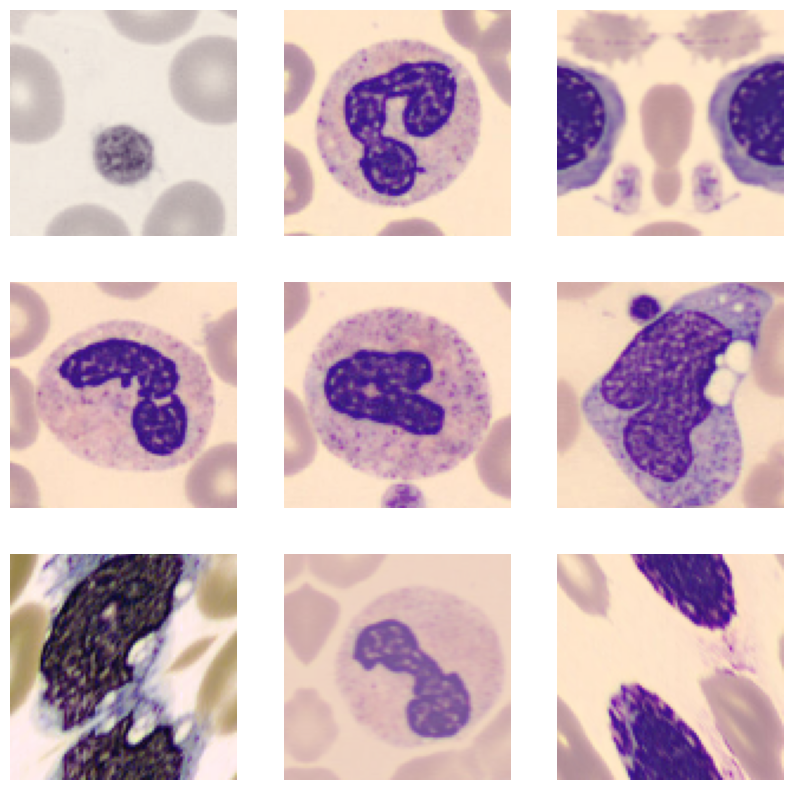

In [ ]:
#Try to augment a portion of the X_train images
image_portion = X_train[:9]
image_portion = data_augmentation(image_portion)

#Plot the augmentations
plt.figure(figsize=(10, 10))
for i in range(9):
   plt.subplot(3, 3, i + 1)
   plt.imshow(image_portion[i])
   plt.axis("off")
plt.show()

In [ ]:
#Convert the data into a more suitable format that speeds up the augmentation a lot
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(512)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(512)

In [ ]:
#wrapper fucntion for the augmentation
def augment_images(image, label):
    image = data_augmentation(image)  # Apply data augmentation to the image
    return image, label  # Return the augmented image and the unchanged label

# Apply the mapping to both Train and Validation sets
train_dataset = train_dataset.map(augment_images, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.map(augment_images, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
# Reconvert the Training and Validation set into numpy arrays
X_train, y_train = [], []
for batch in train_dataset:
    images = batch[0].numpy()
    labels = batch[1].numpy()
    X_train.append(images)
    y_train.append(labels)
X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

del train_dataset

# Convert validation dataset to numpy arrays
X_val, y_val = [], []
for batch in val_dataset:
    images = batch[0].numpy()
    labels = batch[1].numpy()
    X_val.append(images)
    y_val.append(labels)
X_val = np.concatenate(X_val, axis=0)
y_val = np.concatenate(y_val, axis=0)

del val_dataset

# Define Model

In [ ]:
input_shape = (96, 96, 3)
output_shape = 8
learning_rate = 0.001
batch_size = 64
epochs = 300
regularizer = tfk.regularizers.L1L2(l1 = 0.1, l2 = 0.05)


# Slightly change to the model filters w.r.t the previous notebook (from Normalized_Regularized_CNN)
# to reduce the number of parameters
def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=learning_rate,
    regularization = False
):

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_uniform')(input_layer)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    x = tfkl.MaxPooling2D(pool_size=2, strides=3)(x)
    x = tfkl.Dropout(0.2)(x)

    x = tfkl.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_uniform')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)

    x = tfkl.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_uniform')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    x = tfkl.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
    x = tfkl.Dropout(0.2)(x)

    x = tfkl.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_uniform')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    x = tfkl.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
    x = tfkl.Dropout(0.2)(x)

    x = tfkl.GlobalAveragePooling2D()(x)

    if regularization:
        x = tfkl.Dense(units=128, kernel_regularizer= regularizer, kernel_initializer='he_uniform')(x)
    else:
        x = tfkl.Dense(units=128, kernel_initializer='he_uniform')(x)

    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    x = tfkl.Dropout(0.5)(x)

    if regularization:
        output_layer = tfkl.Dense(units=output_shape, kernel_regularizer= regularizer, activation='softmax', kernel_initializer='he_uniform', name='Output')(x)
    else :
        output_layer = tfkl.Dense(units=output_shape, activation='softmax', kernel_initializer='he_uniform', name='Output')(x)

    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tfk.losses.CategoricalCrossentropy()
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model

# Early Stopping

In [ ]:
# Define the patience value for early stopping
patience = 20

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

# L1L2 Model

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ Input (InputLayer)          │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_8 (Conv2D)           │ (None, 96, 96, 64)    │      1,792 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_9       │ (None, 96, 96, 64)    │        256 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation_9 (Activation)   │ (None, 96, 96, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_6             │ (None, 32, 32, 64)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_6 (Dropout)         │ (None, 32, 32, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_9 (Conv2D)           │ (None, 32, 32, 128)   │     73,856 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_10      │ (None, 32, 32, 128)   │        512 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation_10 (Activation)  │ (None, 32, 32, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_10 (Conv2D)          │ (None, 32, 32, 256)   │    295,168 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_11      │ (None, 32, 32, 256)   │      1,024 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation_11 (Activation)  │ (None, 32, 32, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_7             │ (None, 16, 16, 256)   │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_7 (Dropout)         │ (None, 16, 16, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_11 (Conv2D)          │ (None, 16, 16, 256)   │    590,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_12      │ (None, 16, 16, 256)   │      1,024 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation_12 (Activation)  │ (None, 16, 16, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_8             │ (None, 8, 8, 256)     │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_8 (Dropout)         │ (None, 8, 8, 256)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_1  │ (None, 256)           │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 128)           │     32,896 │   Y 

 Total params: 998,152 (3.81 MB)

 Trainable params: 996,488 (3.80 MB)

 Non-trainable params: 1,664 (6.50 KB)

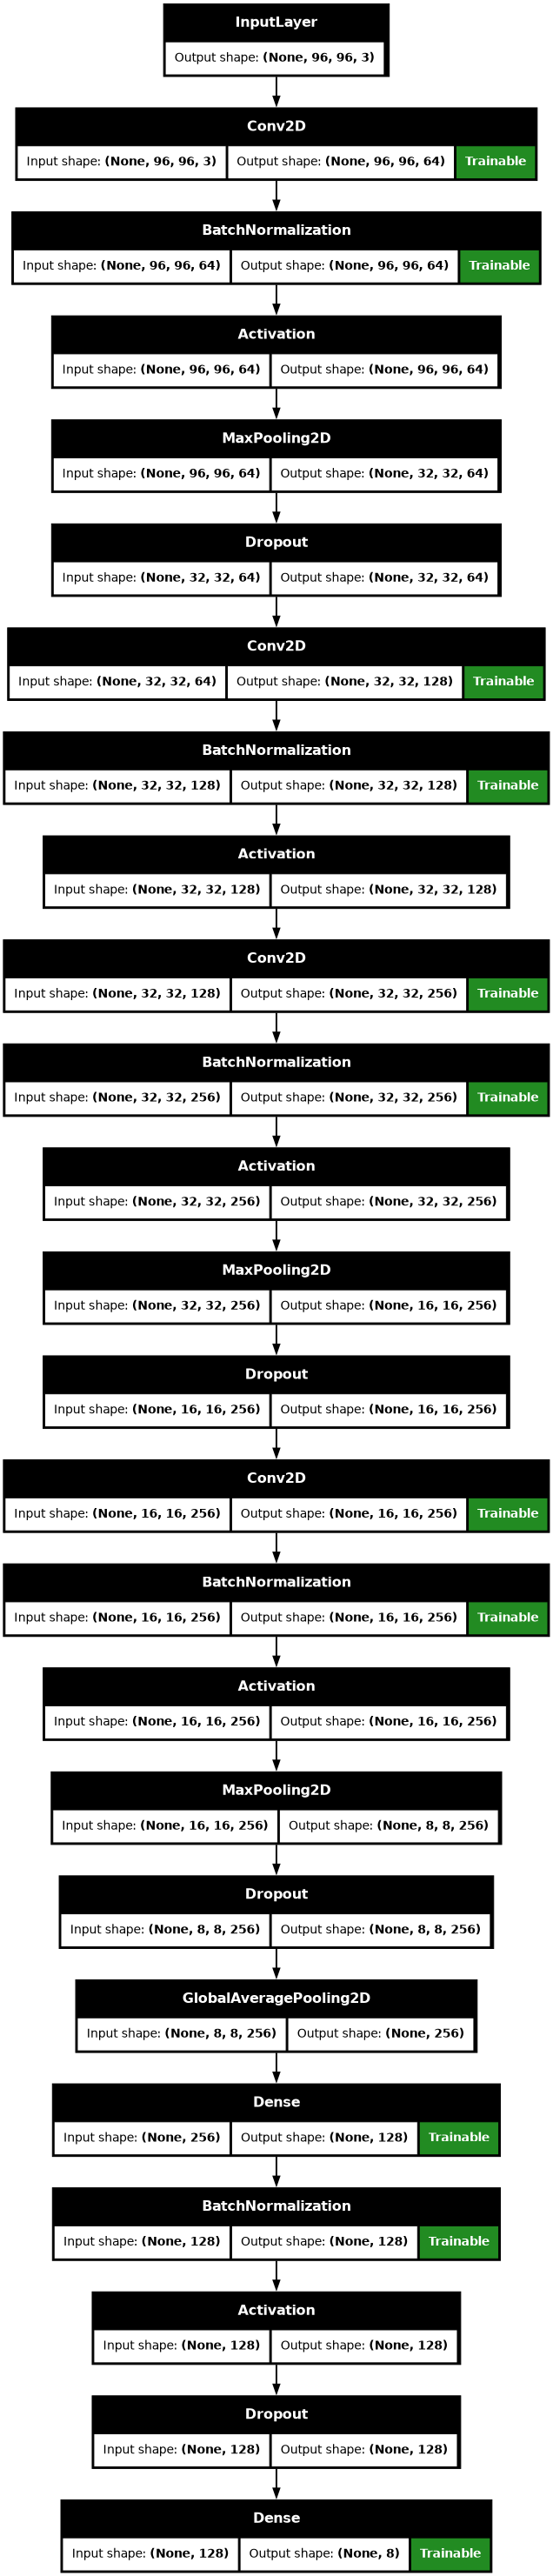

In [ ]:
# Build the model with specified input and output shapes
model = build_model(regularization = True)

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

# Train L1L2 Model

In [ ]:
# Train the model with early stopping callback
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size = batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history




Epoch 1/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - accuracy: 0.3266 - loss: 174.5180 - val_accuracy: 0.1697 - val_loss: 5.8398
Epoch 2/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.4464 - loss: 3.6972 - val_accuracy: 0.2345 - val_loss: 2.5625
Epoch 3/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.3433 - loss: 2.4325 - val_accuracy: 0.2889 - val_loss: 2.4698
Epoch 4/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.3659 - loss: 2.3903 - val_accuracy: 0.3474 - val_loss: 2.3869
Epoch 5/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.3827 - loss: 2.3432 - val_accuracy: 0.4130 - val_loss: 2.3227
Epoch 6/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.3988 - loss: 2.3069 - val_accuracy: 0.4076 - val_loss: 2.2855
Epoch 7/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.3983 - loss: 2.2999 - val_accuracy: 0.4181 - val_loss: 2.2591
Epoch 8/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.4104 - loss: 2.2764

In [ ]:
# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

Final validation accuracy: 50.71%


In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


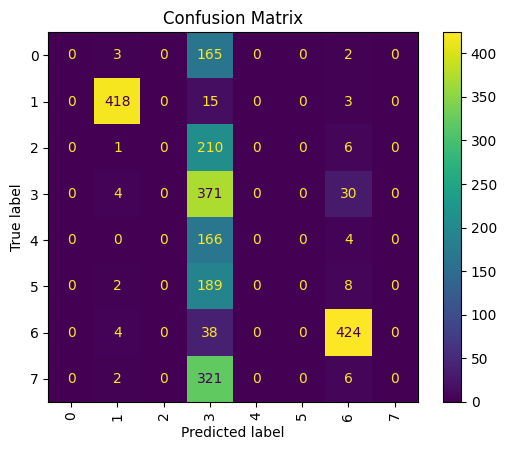

In [ ]:
#Print confusion matrix on the validation set
plot_confusion_matrix(model, X_val, y_val)

In [ ]:
model.save('L1L2.keras')
del model

# Weighted Class Model

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ Input (InputLayer)          │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_12 (Conv2D)          │ (None, 96, 96, 64)    │      1,792 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_14      │ (None, 96, 96, 64)    │        256 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation_14 (Activation)  │ (None, 96, 96, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_9             │ (None, 32, 32, 64)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_10 (Dropout)        │ (None, 32, 32, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_13 (Conv2D)          │ (None, 32, 32, 128)   │     73,856 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_15      │ (None, 32, 32, 128)   │        512 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation_15 (Activation)  │ (None, 32, 32, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_14 (Conv2D)          │ (None, 32, 32, 256)   │    295,168 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_16      │ (None, 32, 32, 256)   │      1,024 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation_16 (Activation)  │ (None, 32, 32, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_10            │ (None, 16, 16, 256)   │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_11 (Dropout)        │ (None, 16, 16, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_15 (Conv2D)          │ (None, 16, 16, 256)   │    590,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_17      │ (None, 16, 16, 256)   │      1,024 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation_17 (Activation)  │ (None, 16, 16, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_11            │ (None, 8, 8, 256)     │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_12 (Dropout)        │ (None, 8, 8, 256)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_2  │ (None, 256)           │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 128)           │     32,896 │   Y 

 Total params: 998,152 (3.81 MB)

 Trainable params: 996,488 (3.80 MB)

 Non-trainable params: 1,664 (6.50 KB)

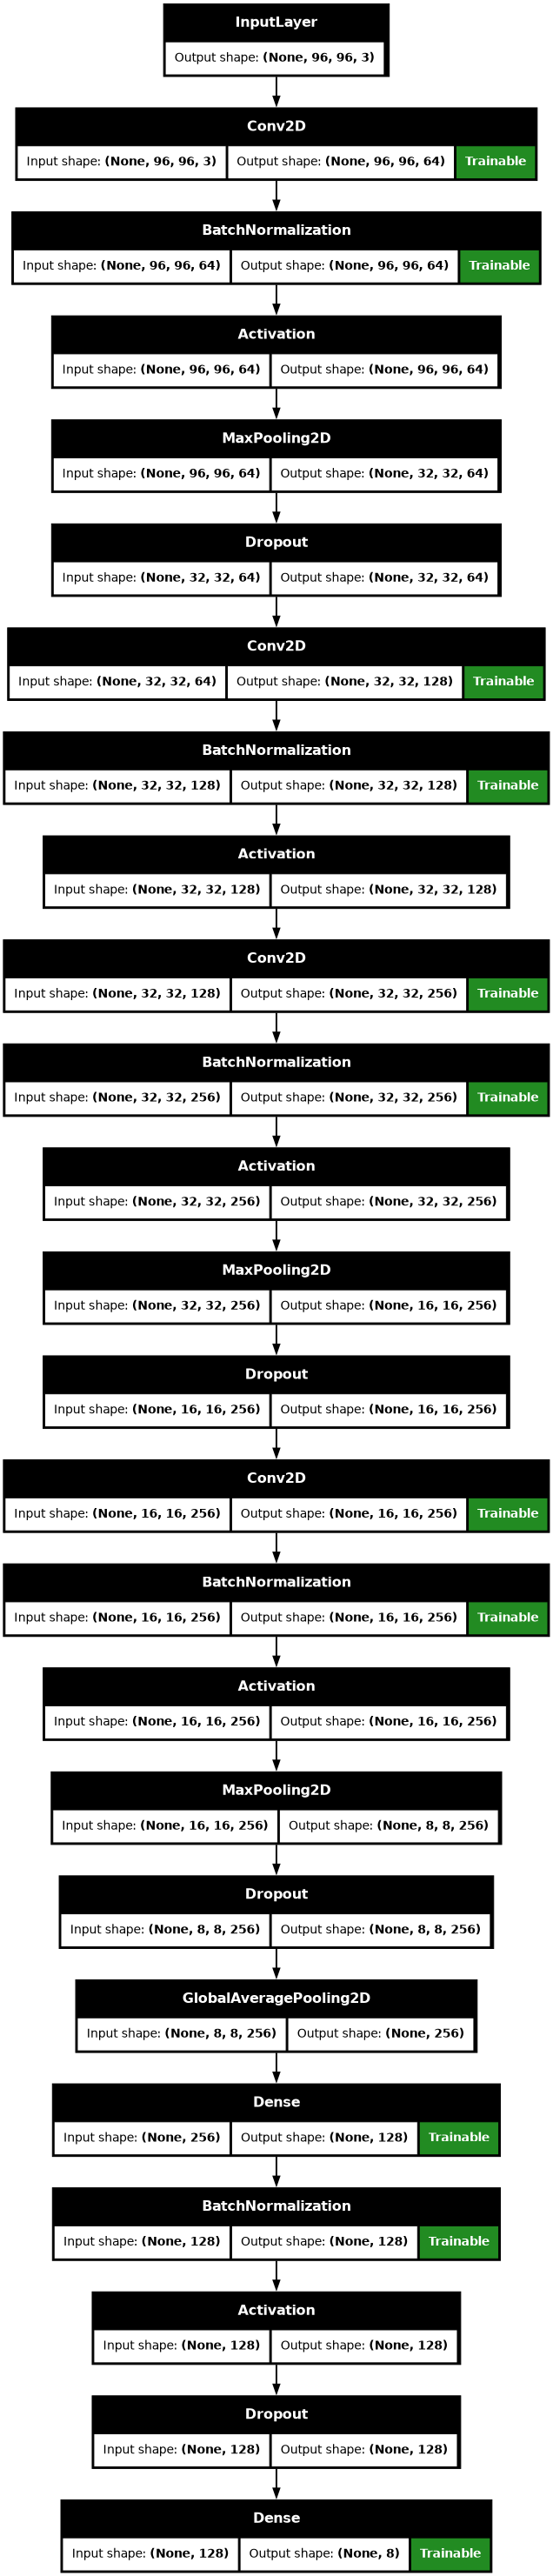

In [ ]:
# Build the model with specified input and output shapes
model = build_model(regularization = False)

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
# Train the model with early stopping callback
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size = batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    class_weight = class_weights_dict
).history



Epoch 1/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - accuracy: 0.2901 - loss: 2.0361 - val_accuracy: 0.2304 - val_loss: 2.1378
Epoch 2/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.5032 - loss: 1.3808 - val_accuracy: 0.4189 - val_loss: 1.5830
Epoch 3/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.5832 - loss: 1.1411 - val_accuracy: 0.4507 - val_loss: 1.4949
Epoch 4/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6151 - loss: 1.0549 - val_accuracy: 0.5514 - val_loss: 1.1874
Epoch 5/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6362 - loss: 0.9831 - val_accuracy: 0.6221 - val_loss: 1.0427
Epoch 6/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6676 - loss: 0.9087 - val_accuracy: 0.6656 - val_loss: 0.9006
Epoch 7/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6938 - loss: 0.8505 - val_accuracy: 0.7383 - val_loss: 0.7431
Epoch 8/300
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7113 - loss: 0.7825 -

In [ ]:
# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')


Final validation accuracy: 88.71%


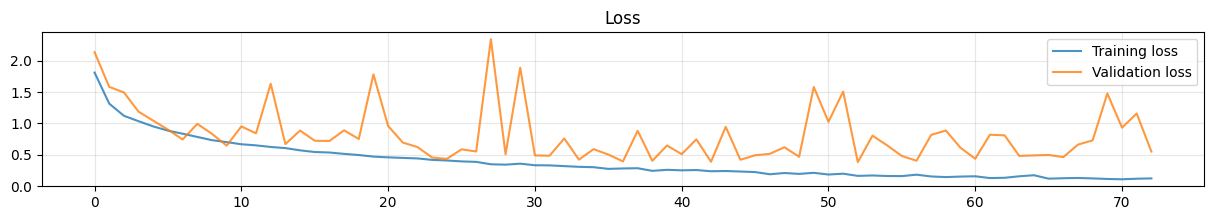

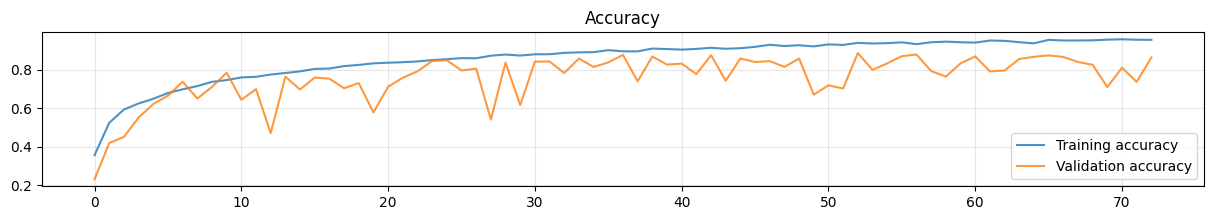

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


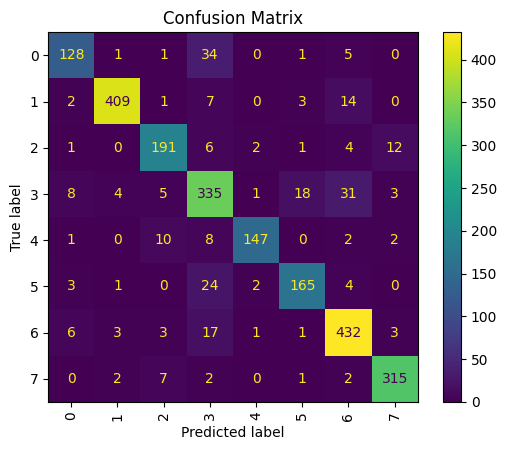

In [ ]:
#Print confusion matrix on the validation set
plot_confusion_matrix(model, X_val, y_val)

In [ ]:
model.save('Weighted_Class.keras')
del model

# 📊 Prepare Your Submission


In [ ]:
#ource = "L1L2.keras"
source = "Weighted_Class.keras"
destination = "weights.keras"

# Take a source an call it "weights.keras"
shutil.copy(source, destination)

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must not be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        # Normalizzare le immagini (applicare la divisione per 255)
        if X.max() > 1.0:  # If max value is greater than 1, assume the range is [0, 255]
            X = X / 255.0


        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
           preds = np.argmax(preds, axis=1)
        return preds



In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras